In [25]:
# Import numpy and matplotlib
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

plt.rcParams["font.size"] = "20"

# Brownian motion


* Observed and described by botanist Robert Brown in 1827
* Small particles in water appeared to move around randomly, and never come to complete rest
* Later (1905) described by Einstein in terms of molecular kinetic theory of heat

## Illustration of Brownian motion (not to scale)
![Illustration of Brownian motion](brownian.gif)

<div style="width:100%;align:center">
<img src="einstein_1.png" alt="Drawing" style="width: 750px;"/>

...


<img src="einstein_2.png" alt="Drawing" style="width: 750px;"/>
</div>

# Einstein's prediction for Brownian motion

$$ \langle x^2 \rangle = 2Dt, \;\; \mathrm{where} \;\; D = \frac{k_B T}{6\pi \mu r}$$

* Here, $\langle x^2 \rangle$ is the mean square displacement of spherical particles of radius $r$ in a fluid with viscosity $\mu$.
* Assumption: we look at an interval $t$ which is long enough that the displacements of a single particle during two consecutive intervals can be assumed mutually independent.
* Measuring $\langle x^2 \rangle$ allows one to calculate Bolzmann's constant, $k_B$, and thus Avogadro's number, $N_A$.

# Measurements done by Perrin (1909)
<div style="float:left;width:700px;font-size:30px">
    <ul>
        <li>Drawing of the path of three particles undergoing Brownian motion</li>
        <li>Positions recorded every 30 seconds</li>
        <li>Average length of a segment is about 9 microns</li>
        <li>Perrin's results seen as quite solid proof for "the atomic theory", which was still debated at the time
    </ul>
</div>
<div style="float:right">
<img src="perrin.png" alt="Drawing" style="width: 550px;"/>
</div>

# The Langevin equation
* Langevin wrote down an equation for Brownian motion on short timescales (Langevin, 1908)
* This is Newton's 2nd law for a spherical particle in a liquid, with Stokes' drag and a random force:

$$ m \frac{\mathrm{d}^2 x}{\mathrm{d} t^2} = - 6 \pi \mu r \frac{\mathrm{d} x}{\mathrm{d} t} + X $$

* "_About the complementary force $X$, we know that it is indifferently positive and negative and that its magnitude is such that it maintains the agitation of the particle, [...]_"

# The Langevin equation

* An early (first?) example of what is now known as a Stochastic Differential Equation (SDE)
* The theory of SDEs was only properly developed in the 1940s, by Itô and others.
* In modern notation, we can give a precise mathematical meaning to the random force in the Langevin equation.


* A note on terminology: The term "Langevin equation" is now used much more generally, for SDEs describing randomly varying degrees of freedom in systems whose average properties change slowly (see, e.g., Coffey et al. 2004)

# Summary so far

We have two different models for Brownian motion:
* Einstein's model, which we call a random walk
* Langevin's model, which we call a random flight

(see, e.g., Lynch et al. (2015), chapter 4)

## Random walk

* During an interval $\Delta t$, the _position_ changes by an amount $\Delta x$
* $\Delta x$ is a Gaussian random number, with zero mean, and standard deviation proportional to $\sqrt{\Delta t}$


## Random flight

* During an inteval $\Delta t$, the _velocity_ changes by an amount $\Delta v$
* $\Delta v$ has two parts:
** A deterministic part, the Stokes' drag
** A random part, Langevin's random force
* The change in position, $\Delta x$, is simply given by $\Delta x = v \, \Delta t$


## Random walk

$$ \mathrm{d} x = \sqrt{2 D} \, \mathrm{d} W_t $$

## Random flight

\begin{align}
    \mathrm{d} v &= - \frac{1}{\tau}v \Delta t +  \gamma \, \mathrm{d} W_t \nonumber \\
    \mathrm{d} x &= v \, \mathrm{d} t \nonumber
    \end{align}

In [34]:
@njit
def random_walk(Np, Tmax, eta, dt = 0.05):
    Nt = int(Tmax/dt)
    X = np.zeros((Np, Nt))
    for i in range(1, Nt):
        dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = Np)
        X[:,i] = X[:,i-1] + eta*dW
    return X

@njit
def random_flight(Np, Tmax, tau, gamma, dt = 0.05):
    Nt = int(Tmax/dt)
    X = np.zeros((Np, Nt))
    V = np.zeros((Np, Nt))
    for i in range(1, Nt):
        dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = Np)
        X[:,i] = X[:,i-1] + V[:,i-1]*dt
        V[:,i] = V[:,i-1] - (1/tau)*V[:,i-1]*dt + gamma*dW
    return X, V

In [44]:
def run_and_plot_both(Np, Tmax, eta, tau, gamma):
    # Run simulations
    X_walk = random_walk(Np, Tmax, eta)
    X_flight, V_flight = random_flight(Np, Tmax, tau, gamma, dt=0.01)

    # Plot results
    fig, ax = plt.subplots(ncols = 2, figsize = (12,5), sharey = True)
    ax[0].plot(np.linspace(0, Tmax, X_walk.shape[-1]), X_walk.T)
    ax[1].plot(np.linspace(0, Tmax, X_flight.shape[-1]), X_flight.T)

    # Axis and labels
    ax[0].set_ylabel('Position')
    ax[0].set_xlabel('Time')
    ax[1].set_xlabel('Time')
    ax[0].set_title('Random walk')
    ax[1].set_title('Random flight')
    plt.tight_layout()
    
def run_and_plot_variance(Np, Tmax, eta, tau, gamma):
    # Run simulations
    X_walk = random_walk(Np, Tmax, eta)
    X_flight, V_flight = random_flight(Np, Tmax, tau, gamma, dt=0.01)

    # Plot variance and trendlines
    fig, ax = plt.subplots(ncols=2, figsize=(12,5), sharex=True, sharey=True)

    times = np.linspace(0, Tmax, X_walk.shape[-1])
    ax[0].plot(times, np.var(X_walk, axis = 0))#, label = 'random walk')
    ax[0].plot(times, eta**2*times, '--', c = 'k', lw = 1, label = '$\eta^2 \, t$')

    times = np.linspace(0, Tmax, X_flight.shape[-1])
    ax[1].plot(times, np.var(X_flight, axis = 0))#, label = 'Random flight')
    ax[1].plot(times, (tau*gamma)**2 * times, '--', c = 'k', lw = 1, label = '$\\tau^2 \gamma^2 \, t$')
    ax[1].plot([tau, tau], [0, 1000], ':', c = 'k', lw = 1, alpha = 0.5)

    # Fix scales and labels
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Time')
    ax[1].set_xlabel('Time')
    ax[0].set_ylabel('Mean square displacement')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Random walk')
    ax[1].set_title('Random flight')
    plt.tight_layout()

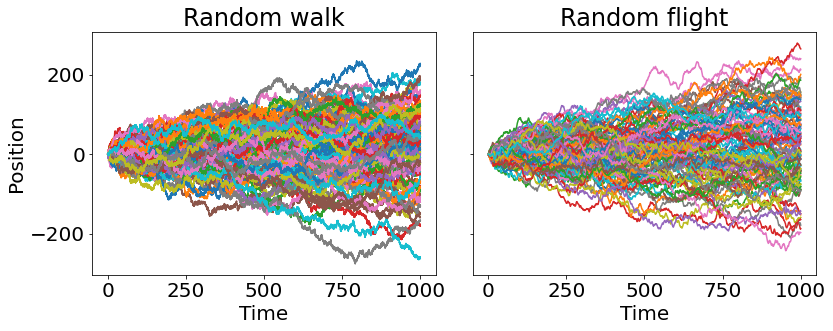

In [45]:
# Numerical parameters
Np = 100
Tmax = 1000

# Equation parameters
eta = 3
tau = 1
gamma = 3

# Run simulations and plot results
run_and_plot_both(Np, Tmax, eta, tau, gamma)

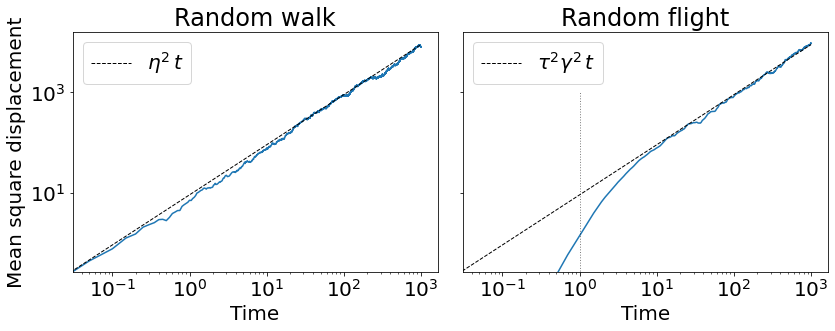

In [46]:
# Numerical parameters
Np = 100
Tmax = 1000

# Equation parameters
eta = 3
tau = 1
gamma = 3

# Run simulations and plot results
run_and_plot_variance(Np, Tmax, eta, tau, gamma)

## Random walk
 * Direction of the next step is independent of the direction of the previous step
 * Average step length proportional to $\sqrt{\Delta t}$
 * "Speed" becomes infinite as $\Delta t \to 0$
 * Consistent with the diffusion equation
 * Mean square displacement (variance) increases linearly in time

## Random flight
 * Direction of the next step is likely to be in same direction as the previous step (for steps shorter than $\tau$)
 * Velocity remains physically reasonable
 * Not consistent with the diffusion equation
 * (But approximately consistent with the diffusion equation for $t \gg \tau$)
 * Mean square displacement increases linearly in time for $t \gg \tau$

## Why is this interesting?
 * Relevant for ocean/atmosphere transport models
 * Random walk/flight used as a model for turbulent mixing
 * On very short timescales, particles carried by turbulence will keep moving in the same direction
 * If we care about long timescales, random walk is probably fine
 * If we care about short timescales, random flight might be better

## Open questions

* When, if ever, should we use random flight models?
* How do we estimate the two parameters (timescale and random force) in the random flight model?

Hopefully, we can address these questions in a new NFR project on oil droplets in breaking waves, which is just starting.

# References and suggested reading

* Einstein (1905), "On the movement of small particles suspened in stationary liquids required by the molecular-kinetic theory of heat", https://einsteinpapers.press.princeton.edu/vol2-trans/137
* Langevin (1908), "On the theory of Brownian motion", https://aapt.scitation.org/doi/10.1119/1.18725
* Perrin (1909), "Brownian movement and molecular reality", http://web.mit.edu/swangroup/footer/perrin_bm.pdf
* Coffey et al. (2005), _The Langevin Equation_, https://www.worldscientific.com/worldscibooks/10.1142/5343
* Lynch et al. (2015), _Particles in the Coastal Ocean_, https://www.cambridge.org/core/books/particles-in-the-coastal-ocean/791F953D7BAC2F77C1013470799E2F94
* Rodean (1996), _Stochastic Lagrangian Models of Turbulent Diffusion_, https://link.springer.com/book/10.1007/978-1-935704-11-9

# Questions?